In [44]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
decay=1
sigma=0.3
zmin=0
zmax=5 # not used
xthresh=1.5
N=10000
z = np.random.exponential(decay,N)
x = np.random.normal(z,sigma,N)
bins=np.linspace(0,zmax,51)

Text(0, 0.5, 'x')

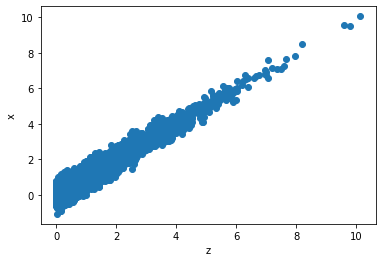

In [4]:
plt.scatter(z,x)
plt.xlabel('z')
plt.ylabel('x')

Text(0.5, 0, 'x-z')

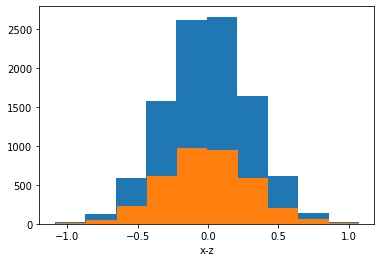

In [5]:
_ = plt.hist(x-z)
_ = plt.hist((x-z)[z>1])
plt.xlabel('x-z')

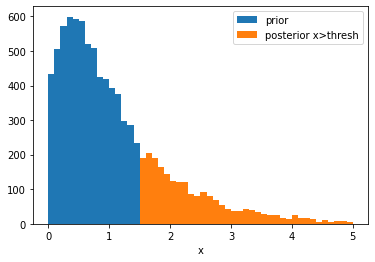

In [6]:
_ = plt.hist(x, bins=bins, label='prior')
_ = plt.hist(x[x>xthresh], bins=bins,label='posterior x>thresh')
plt.xlabel('x')
plt.legend()

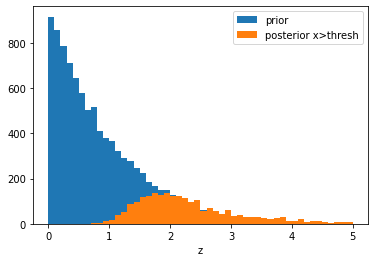

In [7]:
_ = plt.hist(z, bins=bins, label='prior')
_ = plt.hist(z[x>xthresh], bins=bins,label='posterior x>thresh')
plt.xlabel('z')
plt.legend()

The Cell above shows posterior in a case where a mixture of Gaussians might do ok in modelling it. 

# Turn this into PyProb

In [1]:
import pyprob
from pyprob import Model
from scipy import stats

Cannot import dbm.gnu: No module named '_gdbm'


/scratch/mdd424/CGinkgo/lib/python3.7/site-packages/pyprob/util.py:332: UserWarning: Empirical distributions on disk may perform slow because GNU DBM is not available. Please install and configure gdbm library for Python for better speed.
  warnings.warn('Empirical distributions on disk may perform slow because GNU DBM is not available. Please install and configure gdbm library for Python for better speed.')


### Define a simple model reflecting the above distributions

In [34]:
class SimpleSim(Model):
    def __init__(self, bernoulli_func, exp_decay=1.5, exp_low=0, exp_high=1, sigma=0.3):
        super().__init__(name="Simple Simulator")
        self.bernoulli_func = bernoulli_func
        self.exp_decay = exp_decay
        self.exp_low = exp_low
        self.exp_high = exp_high
        self.sigma = sigma
    
    def forward(self):
        # Sample our latent variable
        z = pyprob.sample(pyprob.distributions.TruncatedExponential(self.exp_decay, self.exp_low, self.exp_high),
                          name="latent")
        # Sample our observable
        x = pyprob.sample(pyprob.distributions.Normal(z, self.sigma),
                           name="observed")
        rval = {'latent': z, 'observed': x}
        
        # Define a bernoulli variable that determines whether or not we pass a certain cut criterion
        delta_val = int(self.bernoulli_func(self, rval))
        bool_func_dist = pyprob.distributions.Bernoulli(delta_val)
        pyprob.observe(bool_func_dist, name="bernoulli")
        return rval

### Define a bernoulli variable that determines whether or not we pass a certain cut criterion

In [64]:
threshold = 1
def bernoulli_func(self, result):
    if result["observed"] is None:
        print(result)
    return result["observed"] > threshold

### Make an instance of the simulator

In [95]:
sim = SimpleSim(bernoulli_func, exp_high=5)

### Generate traces from the simulator

In [79]:
prior = sim.prior(num_traces=10*5000)

Time spent  | Time remain.| Progress             | Trace       | Traces/sec
0d:00:01:06 | 0d:00:00:00 | #################### | 50000/50000 | 755.20       


### Filter on those that pass the cut criterion

In [80]:
posterior = prior.filter(lambda t: bernoulli_func(None, t.result))

Filter, min_index: 0, max_index: 50000
Time spent  | Time remain.| Progress             | Values      | Values/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 50000/50000 | 25,587.24       


### Get the latent variable distributions

In [81]:
exp_prior_dist = prior.map(lambda t: t['latent'])
exp_post_dist = posterior.map(lambda t: t['latent'])

Map, min_index: 0, max_index: 50000
Time spent  | Time remain.| Progress             | Values      | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 50000/50000 | 61,176.84       
Map, min_index: 0, max_index: 12371
Time spent  | Time remain.| Progress             | Values      | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 12371/12371 | 23,767.36       


### Check the effective sample sizes

In [82]:
w = exp_prior_dist.weights.numpy()
print("Prior effective sample size:", round(w.sum()**2 / (w**2).sum(), 7))

w = exp_post_dist.weights.numpy()
print("Posterior effective sample size:", round(w.sum()**2 / (w**2).sum(), 7))

Prior effective sample size: 50000.0
Posterior effective sample size: 12371.0


### Use a quick Gaussian KDE to get a continuous view of the posterior (again)

In [83]:
kernel = stats.gaussian_kde([x.item() for x in exp_post_dist.values], weights=exp_post_dist.weights.numpy())

### Visualize the latent variable distribution for the prior and posterior (again)

Text(0, 0.5, 'Normalized Bin Count')

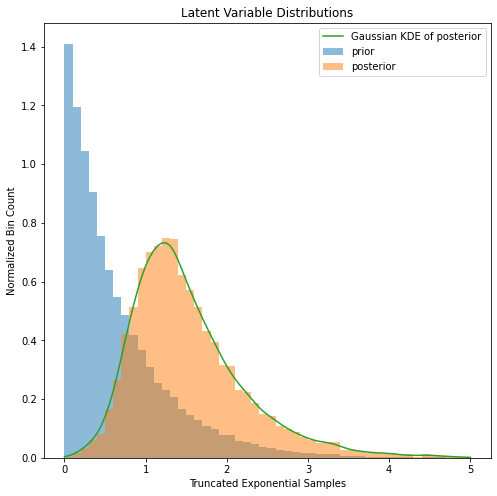

In [84]:
bins = np.linspace(sim.exp_low, sim.exp_high, 51)
kernel_bins = np.linspace(sim.exp_low, sim.exp_high, 101)

fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot(111)

c1,_,_ = ax.hist([x.item() for x in exp_prior_dist.values],
                 weights=exp_prior_dist.weights.numpy(),
                 bins=bins, alpha = 0.5, label='prior', density=True);
c2,_,_ = ax.hist([x.item() for x in exp_post_dist.values],
                 weights=exp_post_dist.weights.numpy(),
                 bins=bins, alpha = 0.5, label = 'posterior', density=True);
ax.plot(kernel_bins, kernel(kernel_bins), label="Gaussian KDE of posterior")

ax.legend()
ax.set_title("Latent Variable Distributions")
ax.set_xlabel('Truncated Exponential Samples')
ax.set_ylabel("Normalized Bin Count")

# Generate the posterior using importance sampling

In [86]:
posterior = sim.posterior(num_traces=10*5000, observe={"bernoulli": 1})

Time spent  | Time remain.| Progress             | Trace       | Traces/sec
0d:00:01:20 | 0d:00:00:00 | #################### | 50000/50000 | 618.36       


## Repeat the above

### Get the latent variable distributions (again)

In [87]:
exp_prior_dist = prior.map(lambda t: t['latent'])
exp_post_dist = posterior.map(lambda t: t['latent'])

Map, min_index: 0, max_index: 50000
Time spent  | Time remain.| Progress             | Values      | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 50000/50000 | 78,057.69       
Map, min_index: 0, max_index: 50000
Time spent  | Time remain.| Progress             | Values      | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 50000/50000 | 89,233.68       


### Check the effective sample sizes (again)

In [88]:
w = exp_prior_dist.weights.numpy()
print("Prior effective sample size:", round(w.sum()**2 / (w**2).sum(), 7))

w = exp_post_dist.weights.numpy()
print("Posterior effective sample size:", round(w.sum()**2 / (w**2).sum(), 7))

Prior effective sample size: 50000.0
Posterior effective sample size: 12388.0089674


### Use a quick Gaussian KDE to get a continuous view of the posterior (again)

In [89]:
kernel = stats.gaussian_kde([x.item() for x in exp_post_dist.values], weights=exp_post_dist.weights.numpy())

### Visualize the latent variable distribution for the prior and posterior (again)

Text(0, 0.5, 'Normalized Bin Count')

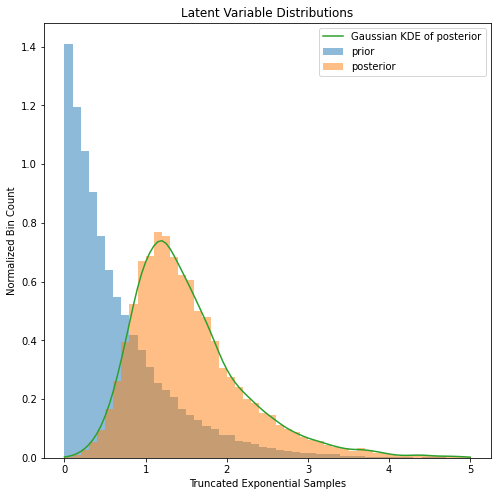

In [90]:
bins = np.linspace(sim.exp_low, sim.exp_high, 51)
kernel_bins = np.linspace(sim.exp_low, sim.exp_high, 101)

fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot(111)

c1,_,_ = ax.hist([x.item() for x in exp_prior_dist.values],
                 weights=exp_prior_dist.weights.numpy(),
                 bins=bins, alpha = 0.5, label='prior', density=True);
c2,_,_ = ax.hist([x.item() for x in exp_post_dist.values],
                 weights=exp_post_dist.weights.numpy(),
                 bins=bins, alpha = 0.5, label = 'posterior', density=True);
ax.plot(kernel_bins, kernel(kernel_bins), label="Gaussian KDE of posterior")

ax.legend()
ax.set_title("Latent Variable Distributions")
ax.set_xlabel('Truncated Exponential Samples')
ax.set_ylabel("Normalized Bin Count")

# Generate the posterior using inference compilation

### Train the inference compilation network

In [96]:
sim.learn_inference_network(
    num_traces=30000,
    proposal_mixture_components=3,
    observe_embeddings={'bernoulli': {'dim': 32, 'depth': 3}}
)

Creating new inference network...
Observable bernoulli: reshape not specified, using shape torch.Size([]).
Observable bernoulli: using embedding dim torch.Size([32]).
Observable bernoulli: observe embedding not specified, using the default FEEDFORWARD.
Observable bernoulli: using embedding depth 3.
Observe embedding dimension: 32
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 28__forward__z__TruncatedExponential__1, distribution: TruncatedExponential
New layers, address: 54__forward__x__Normal__1, distribution: Normal
Total addresses: 2, parameters: 4,658
0d:00:00:58 | 1    | 29,952    | +1.83e+00 | +1.00e-01 | +4.70e-01 | 0d:00:00:20 | +1.00e-03 | 533.1                               
Stop condition reached. num_traces: 30000
0d:00:00:58 | 1    | 30,016    | +1.83e+00 | +1.00e-01 | +2.74e-01 | 0d:00:00:20 | +1.00e-03 | 531.6                               


### Use the network to improve sampling from the posterior

In [98]:
posterior = sim.posterior(num_traces=10*5000,
                          inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK,
                          observe={"bernoulli": 1})

Time spent  | Time remain.| Progress             | Trace       | Traces/sec
0d:00:05:32 | 0d:00:00:00 | #################### | 50000/50000 | 150.57       


### Get the latent variable distributions (again)

In [99]:
exp_prior_dist = prior.map(lambda t: t['latent'])
exp_post_dist = posterior.map(lambda t: t['latent'])

Map, min_index: 0, max_index: 50000
Time spent  | Time remain.| Progress             | Values      | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 50000/50000 | 78,576.67       
Map, min_index: 0, max_index: 50000
Time spent  | Time remain.| Progress             | Values      | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 50000/50000 | 100,622.29       


### Check the effective sample sizes (again)

In [100]:
w = exp_prior_dist.weights.numpy()
print("Prior effective sample size:", round(w.sum()**2 / (w**2).sum(), 7))

w = exp_post_dist.weights.numpy()
print("Posterior effective sample size:", round(w.sum()**2 / (w**2).sum(), 7))

Prior effective sample size: 50000.0
Posterior effective sample size: 23199.9207079


### Use a quick Gaussian KDE to get a continuous view of the posterior

In [101]:
kernel = stats.gaussian_kde([x.item() for x in exp_post_dist.values], weights=exp_post_dist.weights.numpy())

### Visualize the latent variable distribution for the prior and posterior

Text(0, 0.5, 'Normalized Bin Count')

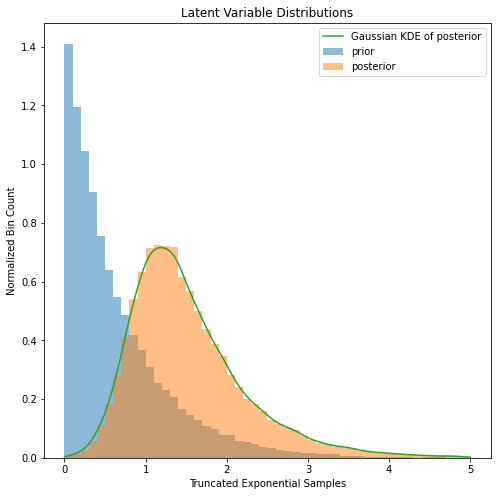

In [102]:
bins = np.linspace(sim.exp_low, sim.exp_high, 51)
kernel_bins = np.linspace(sim.exp_low, sim.exp_high, 101)

fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot(111)

c1,_,_ = ax.hist([x.item() for x in exp_prior_dist.values],
                 weights=exp_prior_dist.weights.numpy(),
                 bins=bins, alpha = 0.5, label='prior', density=True);
c2,_,_ = ax.hist([x.item() for x in exp_post_dist.values],
                 weights=exp_post_dist.weights.numpy(),
                 bins=bins, alpha = 0.5, label = 'posterior', density=True);
ax.plot(kernel_bins, kernel(kernel_bins), label="Gaussian KDE of posterior")

ax.legend()
ax.set_title("Latent Variable Distributions")
ax.set_xlabel('Truncated Exponential Samples')
ax.set_ylabel("Normalized Bin Count")